<a href="https://colab.research.google.com/github/loicmarx/datascience-projects/blob/main/Big_Mart_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, we will help the company to make better marketing decision.
This is a regression problem as we will build up use a machine learning model that predict the sales.

We will use the Big Mart sales data available here: https://www.kaggle.com/brijbhushannanda1979/bigmart-sales-data. 

Importing the depedencies

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

 Data Collection & Analysis

In [57]:
# Loading the dataset from csv file to pandas dataFrame
big_mart_data = pd.read_csv("/content/Train.csv")

In [58]:
# print the first 5 row of the data frame
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [59]:
# Number of data points and number of features
big_mart_data.shape

(8523, 12)

In [60]:
# Getting some information about the dataset
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


We have different type of data in this dataframe:
Categorical features : 
- Item_identifier
- Item_Fat_Content
- Item_Type  
- Outlet_Identifier
- Outlet_Size
- Outlet_Location_Type
- Outlet_Type

In [61]:
# Looking if the dataset has any missing values
big_mart_data.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Handling missing values

- Mean : Average value
- Mode : Most repeted value
> Regarding Outlet_Size, we cannot find the mean value because it is categorical





In [62]:
big_mart_data["Item_Weight"].mean()

12.857645184136183

In [63]:
# Filling the missing values in "Item_Weight" column with mean values
big_mart_data["Item_Weight"].fillna(big_mart_data["Item_Weight"].mean(), inplace=True)

In [64]:
big_mart_data.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [65]:
# Replacing the missing values in "Outlet_Size" with mode
mode_of_outlet_size = big_mart_data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x: x.mode()[0]))

In [66]:
print(mode_of_outlet_size)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2 Supermarket Type3
Outlet_Size         Small             Small            Medium            Medium


Here we took 2 column : Outlet_Size and Outlet_Type because these 2 columns are correlated. We have the mode of each outlet Type. In these missing values, we take the outlet_type that is known and check the mode that we calculated beforehand. All the missing values will be replaced depending on the outlet type.

In [67]:
# Check for missing value , if it's True it means that the value is missing
missing_values = big_mart_data['Outlet_Size'].isnull()
print(missing_values)

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool


In [68]:
big_mart_data.loc[missing_values, 'Outlet_Size'] = big_mart_data.loc[missing_values, 'Outlet_Type'].apply(lambda x: mode_of_outlet_size[x])

In [69]:
big_mart_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

Data Analysis

In [70]:
# Provide statistical measures about the data
big_mart_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Numerical Features

In [71]:
sns.set()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


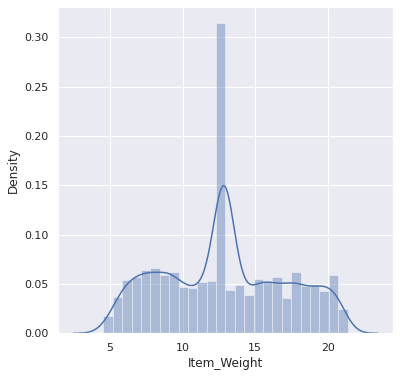

In [72]:
# Item_Weigth distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_Weight'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


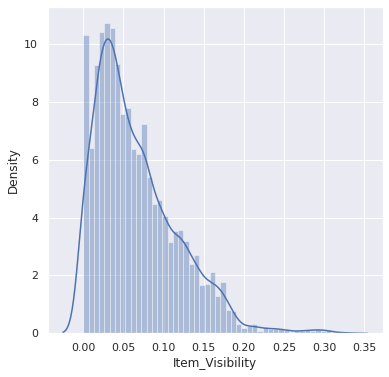

In [73]:
# Item_Visibility distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_Visibility'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


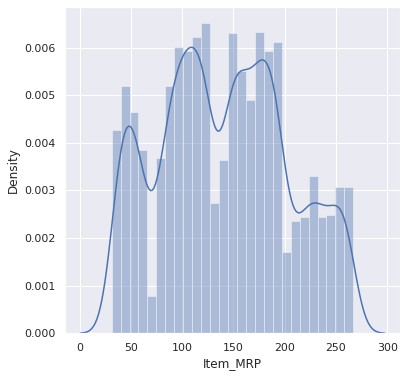

In [74]:
# Item_MRP distribution (Distribution of price value)
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_MRP'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


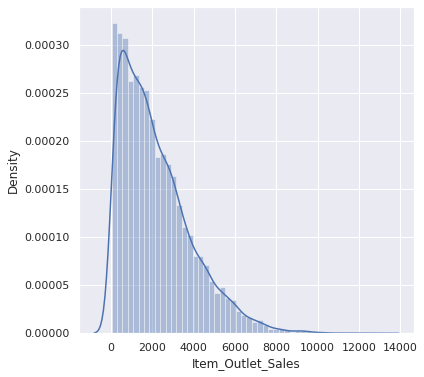

In [75]:
# Item_Outlet_Sales distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_Outlet_Sales'])
plt.show()

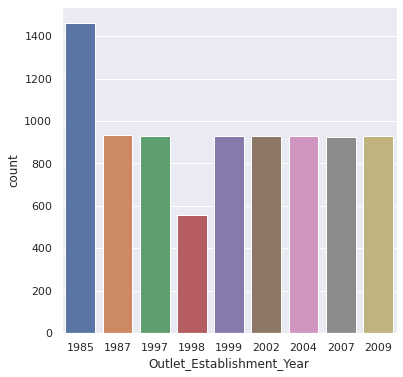

In [76]:
# Outlet_Establishment_Year column : How many product 
plt.figure(figsize=(6,6))
sns.countplot(x = 'Outlet_Establishment_Year', data = big_mart_data)
plt.show()

Categorical features

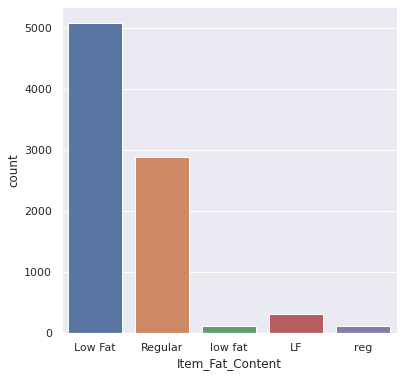

In [77]:
plt.figure(figsize=(6,6))
sns.countplot(x = 'Item_Fat_Content', data = big_mart_data)
plt.show()

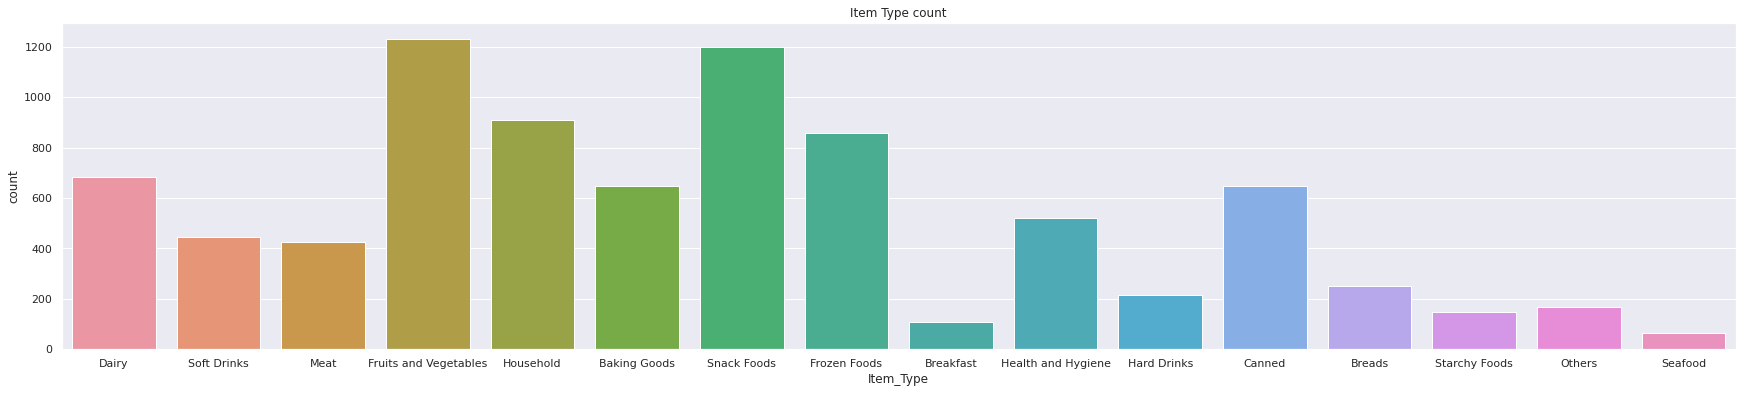

In [78]:
# The data are not clean because Low_fat is separated in 2 category and also the regular. We will need to clean up that data
# Item type column 
plt.figure(figsize=(30,6))
sns.countplot(x = 'Item_Type', data = big_mart_data)
plt.title('Item Type count')
plt.show()


In [79]:
big_mart_data['Outlet_Size'].describe()


count      8523
unique        3
top       Small
freq       4798
Name: Outlet_Size, dtype: object

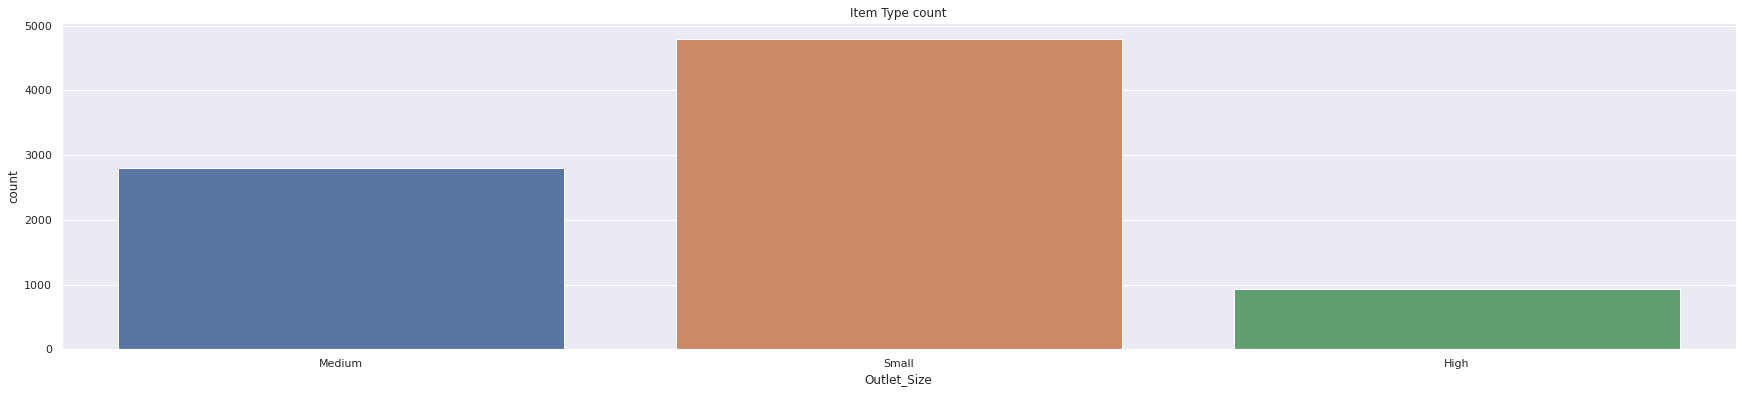

In [80]:
plt.figure(figsize=(30,6))
sns.countplot(x = 'Outlet_Size', data = big_mart_data)
plt.title('Item Type count')
plt.show()

In [81]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [82]:
big_mart_data['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [83]:
# Reorganized the data 
big_mart_data.replace({'Item_Fat_Content' : {'low fat': 'Low Fat', 'LF':'Low Fat', 'reg': 'Regular'}}, inplace =True)

In [84]:
# Check again our data 
big_mart_data['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

Label Encoding 


In [85]:
encoder = LabelEncoder()

In [86]:
big_mart_data['Item_Identifier'] = encoder.fit_transform(big_mart_data['Item_Identifier'])

big_mart_data['Item_Fat_Content'] = encoder.fit_transform(big_mart_data['Item_Fat_Content'])

big_mart_data['Item_Type'] = encoder.fit_transform(big_mart_data['Item_Type'])

big_mart_data['Outlet_Identifier'] = encoder.fit_transform(big_mart_data['Outlet_Identifier'])

big_mart_data['Outlet_Size'] = encoder.fit_transform(big_mart_data['Outlet_Size'])

big_mart_data['Outlet_Location_Type'] = encoder.fit_transform(big_mart_data['Outlet_Location_Type'])

big_mart_data['Outlet_Type'] = encoder.fit_transform(big_mart_data['Outlet_Type'])

In [87]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


Splitting features and Target


In [88]:
X = big_mart_data.drop(columns='Item_Outlet_Sales', axis=1)
Y = big_mart_data['Item_Outlet_Sales']

In [89]:
print(X)

      Item_Identifier  Item_Weight  ...  Outlet_Location_Type  Outlet_Type
0                 156        9.300  ...                     0            1
1                   8        5.920  ...                     2            2
2                 662       17.500  ...                     0            1
3                1121       19.200  ...                     2            0
4                1297        8.930  ...                     2            1
...               ...          ...  ...                   ...          ...
8518              370        6.865  ...                     2            1
8519              897        8.380  ...                     1            1
8520             1357       10.600  ...                     1            1
8521              681        7.210  ...                     2            2
8522               50       14.800  ...                     0            1

[8523 rows x 11 columns]


In [90]:
print(Y)

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64


Splitting the data into Training data & Testing Data


In [91]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2) # use randon_state for identification number and split the same way among different project


In [92]:
print(X.shape, X_train.shape, X_test.shape)

(8523, 11) (6818, 11) (1705, 11)


Training our Machine Learning Model with XGBoost Regressor


In [93]:
# Instantiate the model
regressor = XGBRegressor()

In [94]:
# Fit the model
regressor.fit(X_train, Y_train)

[16:31:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

Evaluation of the model

In [96]:
# prediction on training data
training_data_prediction = regressor.predict(X_train)

In [97]:
# R squared Value
r2_train = metrics.r2_score(Y_train, training_data_prediction)

In [98]:
print('R Squared value = ', r2_train)

R Squared value =  0.6364457030941357


In [99]:
# prediction on test data
test_data_prediction = regressor.predict(X_test)

In [100]:
# R squared Value
r2_test = metrics.r2_score(Y_test, test_data_prediction)

In [101]:
print('R Squared value = ', r2_test)

R Squared value =  0.5867640914432671
